In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
data_path = r".\data\bank+marketing\bank\bank-full.csv"
# Chọn ký tự phân tách dữ liệu, trong trường hợp này là dấu ';'
df = pd.read_csv(data_path, sep=';')

# Kiểm tra kiểu dữ liệu của mỗi cột
print(df.dtypes)

# Thống kê số lượng thuộc tính theo kiểu dữ liệu
print("\nSố lượng đặc trưng theo kiểu dữ liệu:")
print(df.dtypes.value_counts())

# Kiểm tra một số dòng đầu tiên để xem dữ liệu thực tế
print("\nMẫu dữ liệu:")
print(df.head())

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Số lượng đặc trưng theo kiểu dữ liệu:
object    10
int64      7
Name: count, dtype: int64

Mẫu dữ liệu:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may 

In [ ]:
# Tách dữ liệu số (numberical) và dữ liệu dạng phân loại (categorical)
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Tách target và features của lớp dữ liệu categorical
categorical_features.remove('y')  

# Khởi tạo các bộ tiền xử lý
    # Mã hóa one-hot, 
    # drop='first': bỏ cột đầu tiên để tránh giả định thứ tự
    # handle_unknown='ignore': các giá trị trống sẽ mặc định là 0
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')  
    # Chuẩn hóa các đặc trưng số về phân phối chuẩn
scaler = StandardScaler()

# Tiền xử lý dữ liệu
preprocessor = ColumnTransformer([
    ('num', scaler, numerical_features),
    ('cat', ohe, categorical_features) 
])

# Chia tập dữ liệu theo thời gian (mô phỏng bằng cách chia 80-20)
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False, randomstate=42)
X_train, y_train = df_train.drop(columns=['y']), df_train['y']
X_test, y_test = df_test.drop(columns=['y']), df_test['y']

# Chuyển nhãn thành 0/1
y_train = y_train.map({'no': 0, 'yes': 1})  
y_test = y_test.map({'no': 0, 'yes': 1})

# Xây dựng mô hình và tìm tham số tối ưu bằng grid research
grid_params = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Chọn hệ số regularization
    'logreg__solver': ['liblinear', 'lbfgs']  # Lựa chọn thuật toán 
}
# Tạo dựng mô hình bằng Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

grid_search = GridSearchCV(pipeline, grid_params, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)

# Đánh giá mô hình
y_pred = grid_search.best_estimator_.predict(X_test)
print("Best parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'logreg__C': 0.01, 'logreg__solver': 'lbfgs'}
Accuracy: 0.6968926241291606
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      6187
           1       0.71      0.07      0.12      2856

    accuracy                           0.70      9043
   macro avg       0.70      0.53      0.47      9043
weighted avg       0.70      0.70      0.60      9043



d:\HCMUTE_2021_2025\Nam4\AIFA\myenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


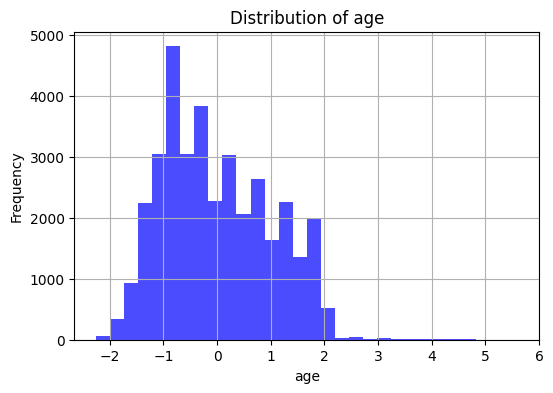

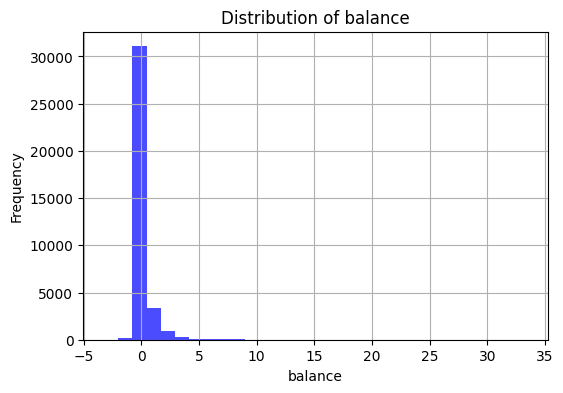

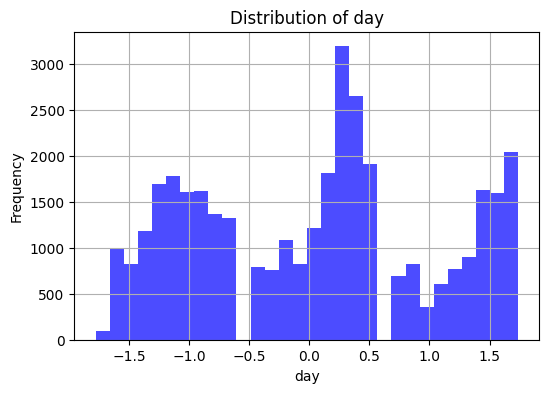

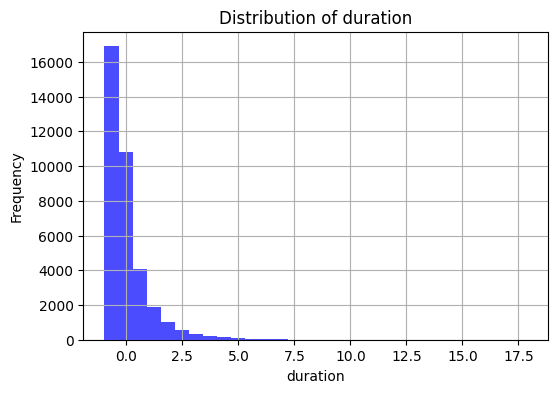

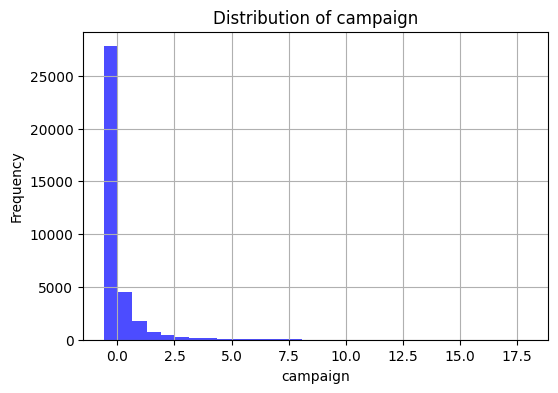

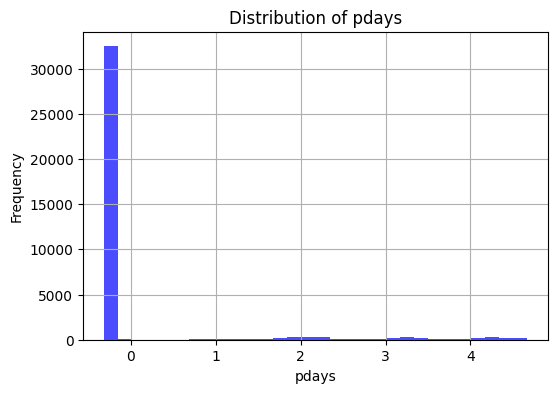

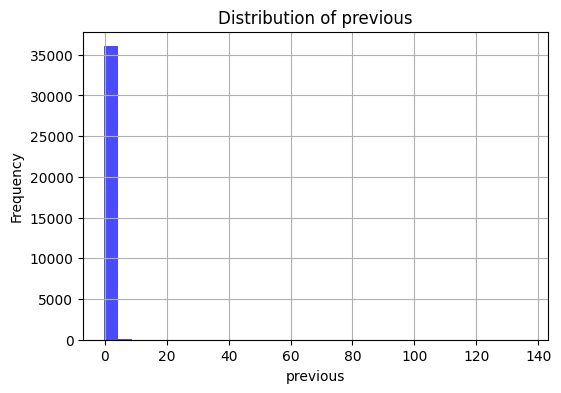

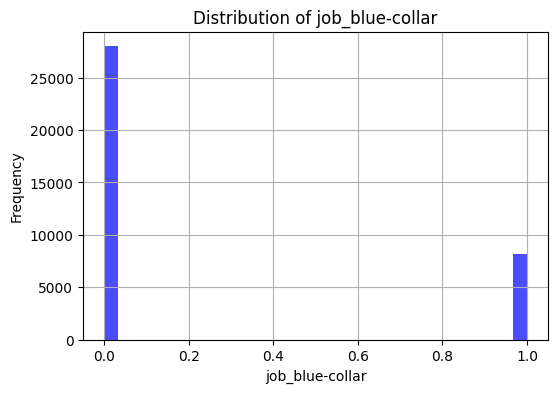

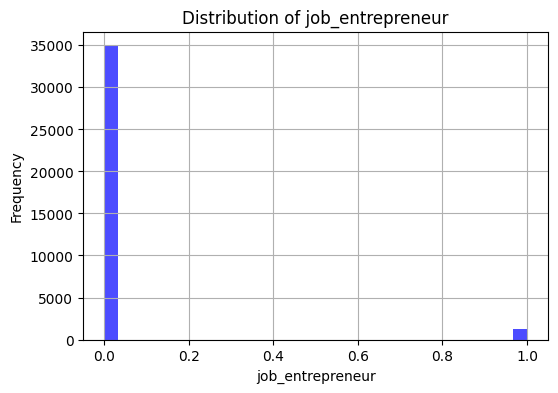

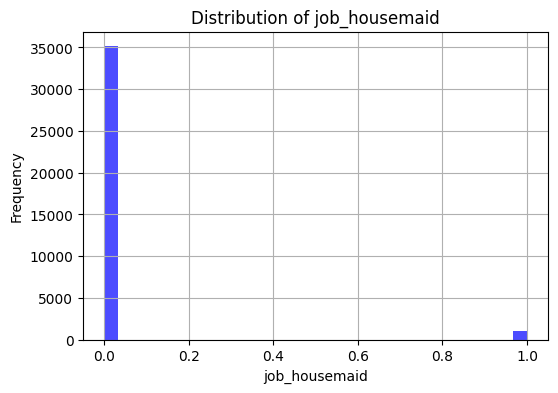

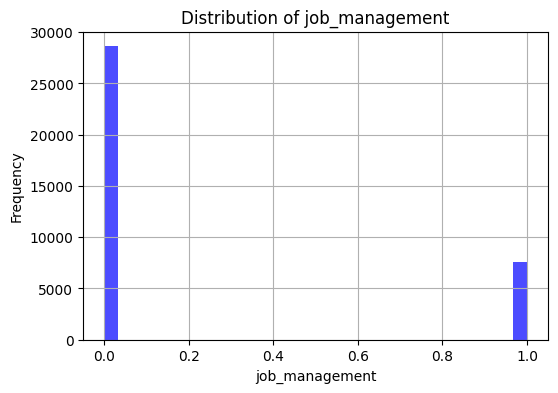

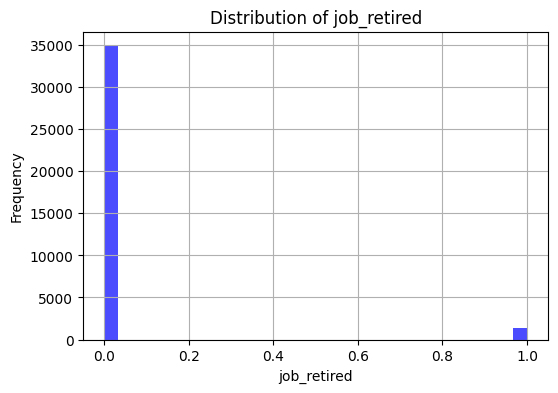

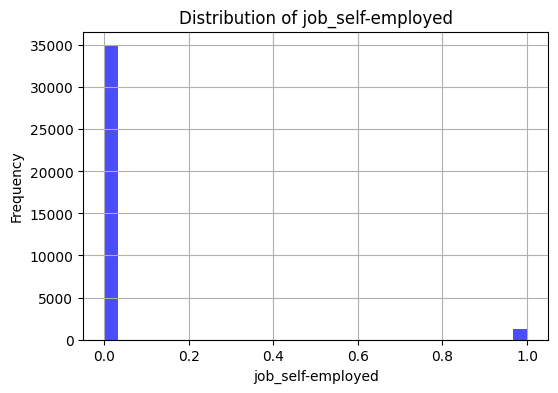

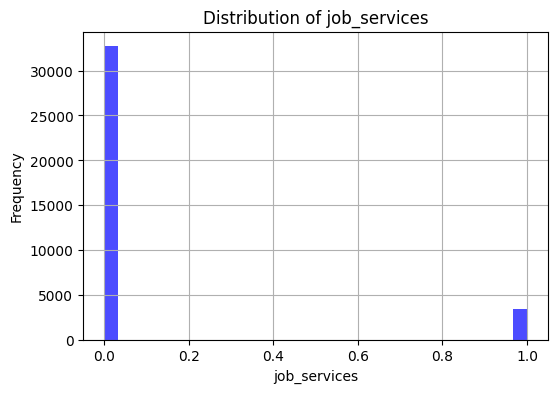

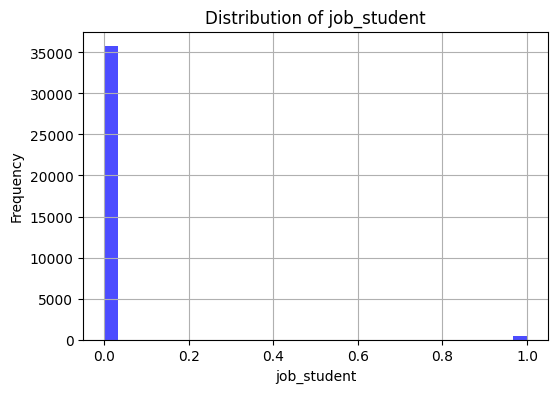

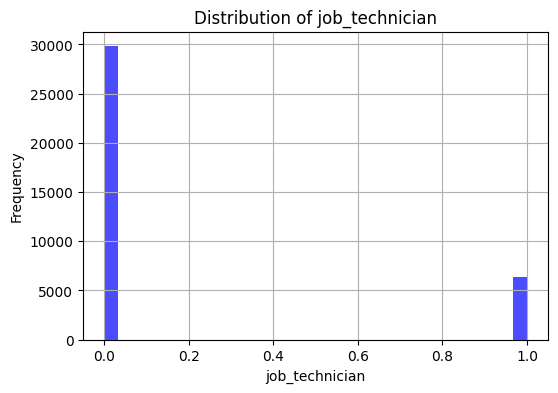

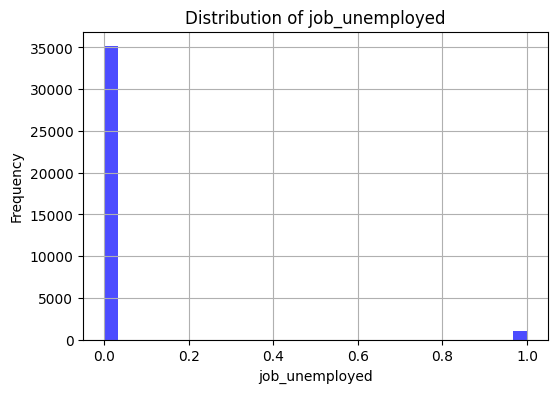

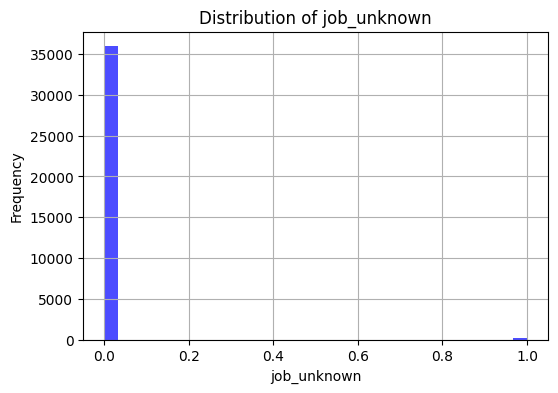

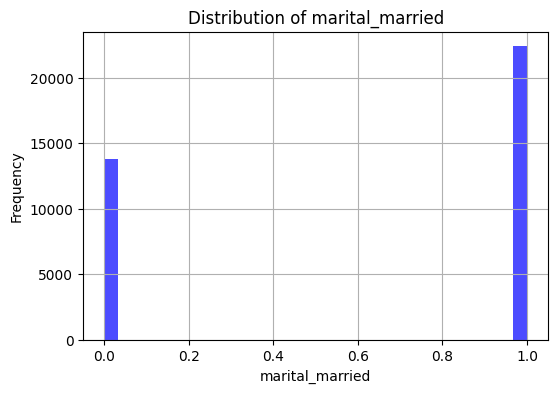

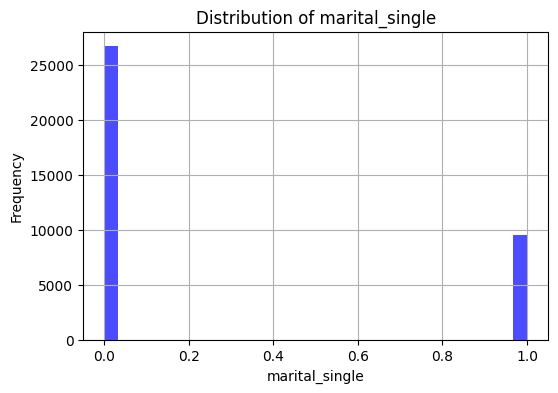

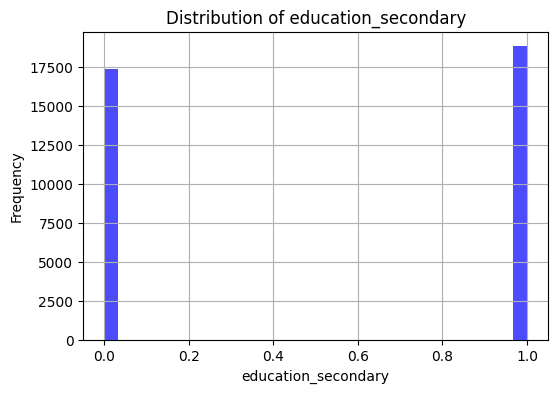

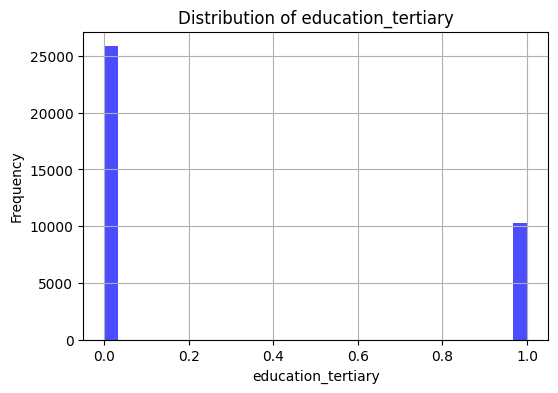

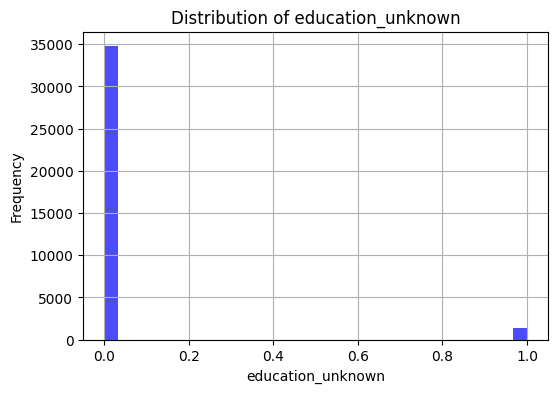

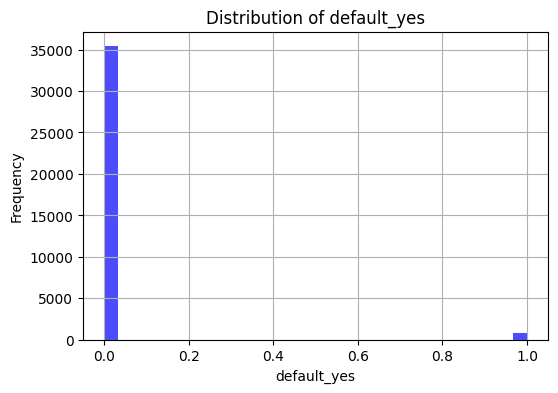

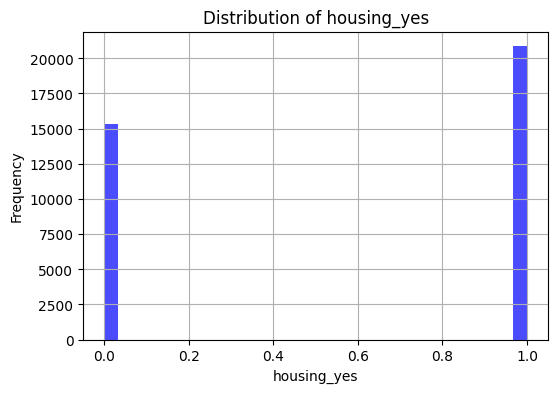

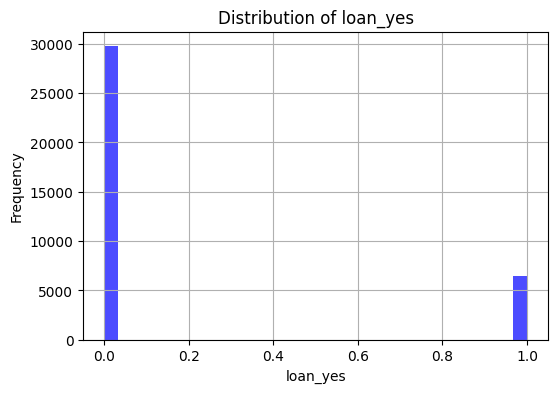

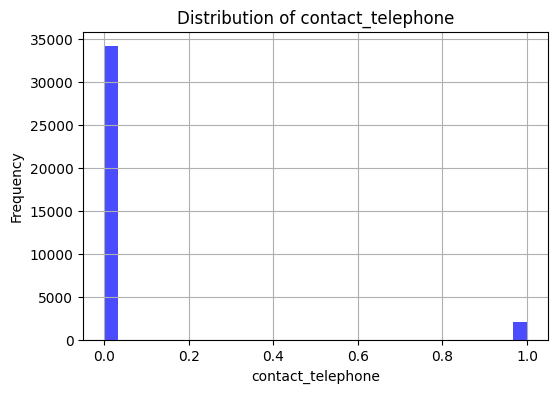

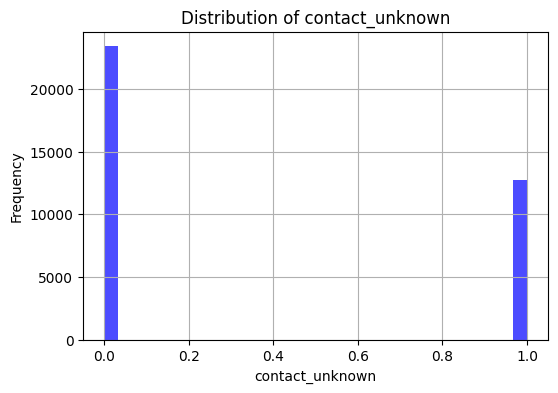

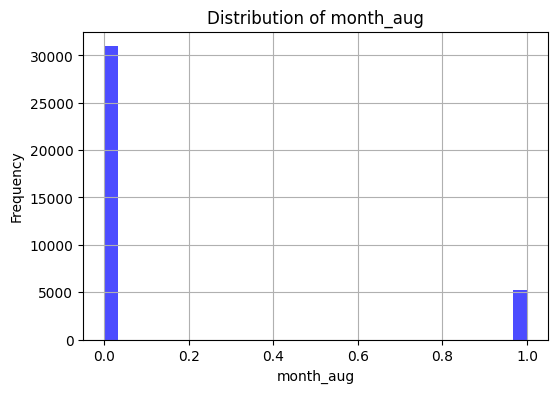

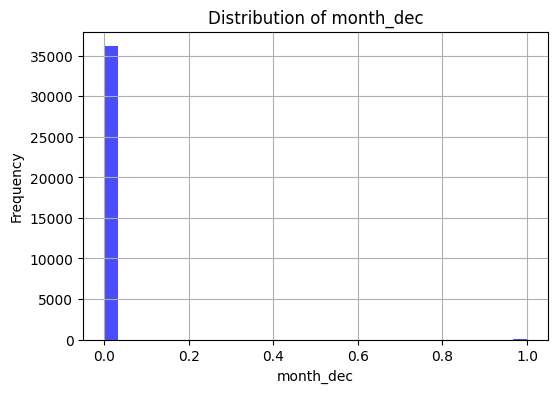

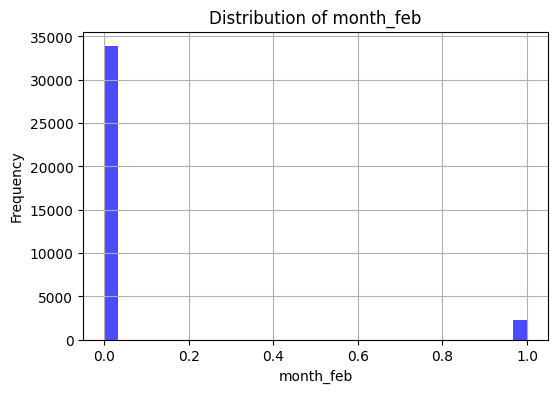

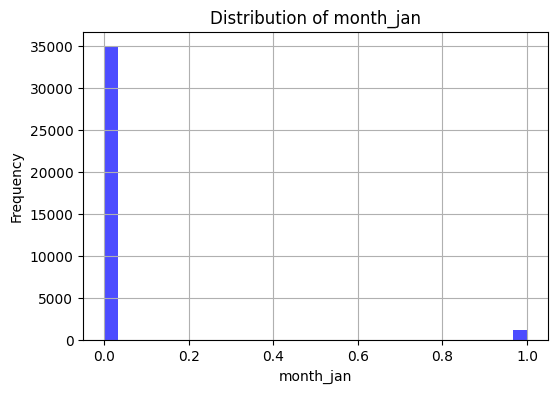

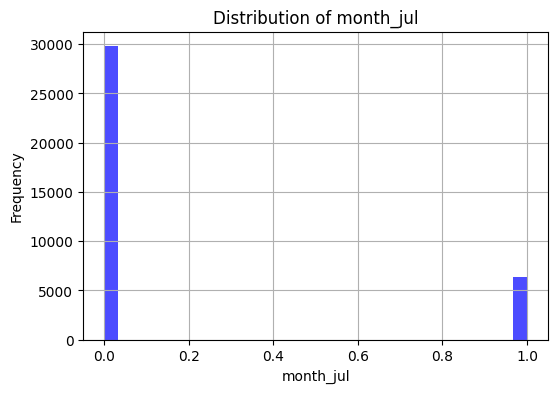

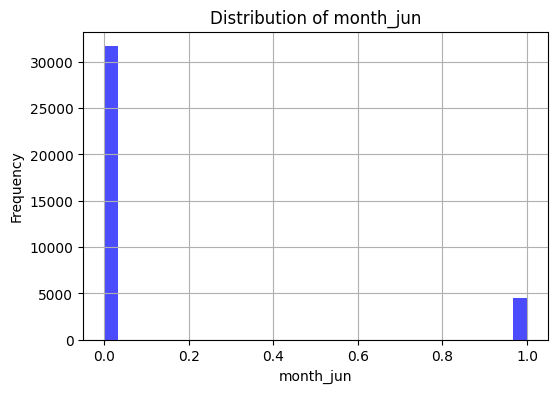

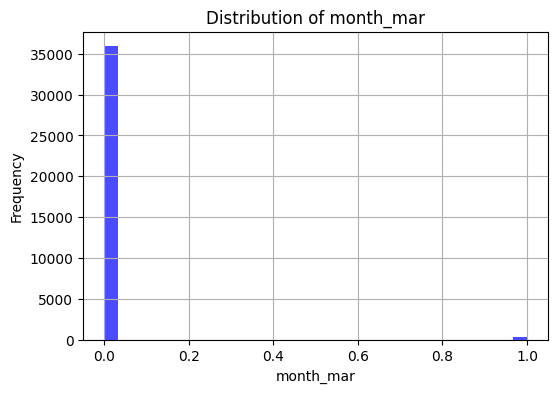

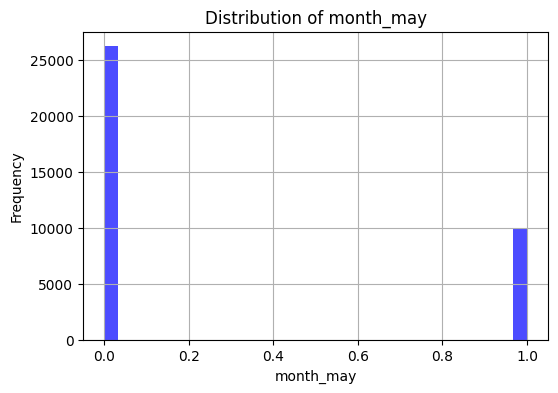

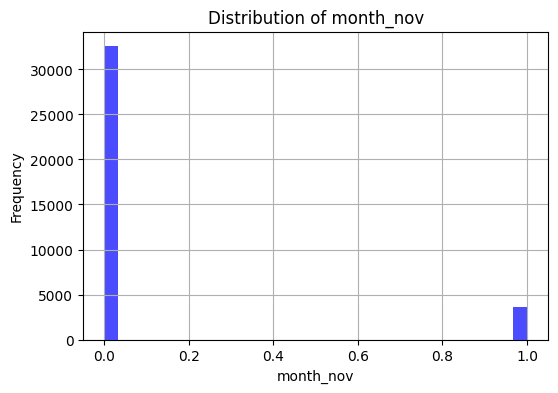

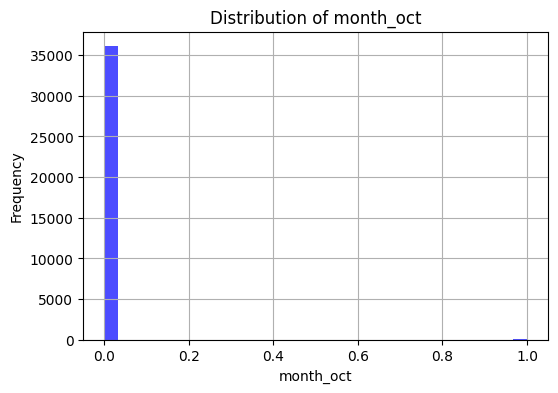

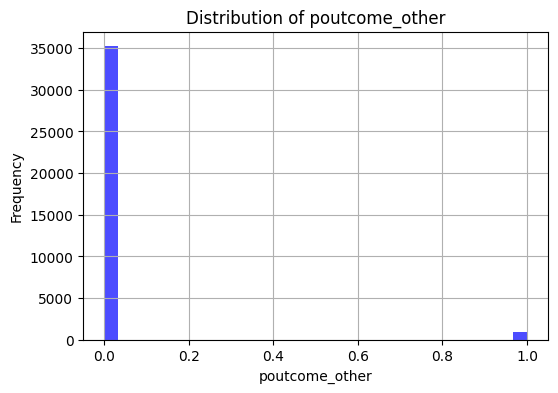

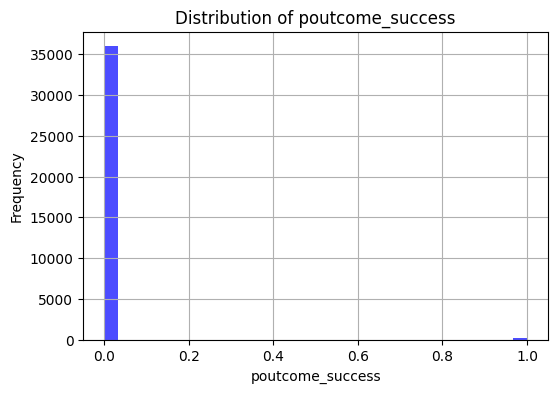

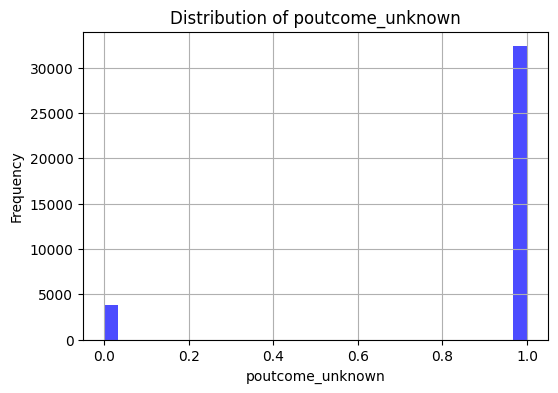

In [ ]:
# Vẽ các đặc trưng sau khi chuyển đổi thành dạng số
X_train_transformed = preprocessor.fit_transform(X_train)
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

for i, feature in enumerate(feature_names):
    plt.figure(figsize=(6, 4))
    plt.hist(X_train_transformed[:, i], bins=30, alpha=0.7, color='b')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
    plt.grid()
    plt.show()

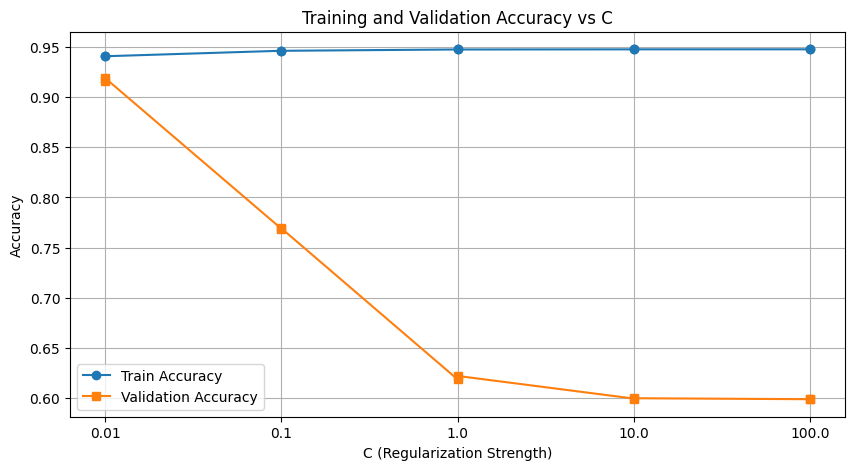

In [ ]:


train_scores = grid_search.cv_results_['mean_train_score']
valid_scores = grid_search.cv_results_['mean_test_score']
param_values = [str(p) for p in grid_search.cv_results_['param_logreg__C']]

plt.figure(figsize=(10, 5))
plt.plot(param_values, train_scores, label='Train Accuracy', marker='o')
plt.plot(param_values, valid_scores, label='Validation Accuracy', marker='s')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs C')
plt.legend()
plt.grid()
plt.show()